# **Reading NMSG Data**

In [1]:
from src.components.data_ingestion import DataLoader

data_directory = '../Data/train_data/'
data_loader = DataLoader(data_directory, columns=["DT","SERVER","NMSG", "TO500RT"])
df_full = data_loader.load_all_parquet_files()
df_full.head()

,DT,SERVER,NMSG,TO500RT
0,2024-01-19 09:06:00,simislnxnss00.si.it,6908.0,0.0
1,2024-01-19 09:06:00,simislnxnss01.si.it,5764.0,0.0
2,2024-01-19 09:06:00,simislnxnss02.si.it,6190.0,0.0
3,2024-01-19 09:07:00,simislnxnss00.si.it,7037.0,0.0
4,2024-01-19 09:07:00,simislnxnss01.si.it,5909.0,0.0


In [2]:
import pandas as pd

# Assuming df_full is your dataframe containing the data
# Convert the 'DT' column to datetime format
df_full['DT'] = pd.to_datetime(df_full['DT'])

# Group the data by hour and aggregate the values in 'NMSG' and 'TO500RT' columns
df_hourly = df_full.groupby(df_full['DT'].dt.strftime('%Y-%m-%d %H')).agg({'NMSG': 'sum', 'TO500RT': 'sum'}).reset_index()



In [3]:
df_full.head()

,DT,SERVER,NMSG,TO500RT
0,2024-01-19 09:06:00,simislnxnss00.si.it,6908.0,0.0
1,2024-01-19 09:06:00,simislnxnss01.si.it,5764.0,0.0
2,2024-01-19 09:06:00,simislnxnss02.si.it,6190.0,0.0
3,2024-01-19 09:07:00,simislnxnss00.si.it,7037.0,0.0
4,2024-01-19 09:07:00,simislnxnss01.si.it,5909.0,0.0


In [4]:
df_hourly

,DT,NMSG,TO500RT
0,2021-01-01 00,72996.0,3.0
1,2021-01-01 01,87988.0,2.0
2,2021-01-01 02,107231.0,4.0
3,2021-01-01 03,49309.0,1.0
4,2021-01-01 04,92361.0,1.0
...,...,...,...
27249,2024-02-12 12,1456545.0,20.0
27250,2024-02-12 13,1251404.0,18.0
27251,2024-02-12 14,1028825.0,19.0
27252,2024-02-12 15,1086515.0,17.0


In [5]:
df_hourly['ANOMALY'] = df_hourly.apply(lambda row: 'YES' if (row['TO500RT'] / row['NMSG'] * 100 > 0.01) else 'NO', axis=1)
df_hourly


,DT,NMSG,TO500RT,ANOMALY
0,2021-01-01 00,72996.0,3.0,NO
1,2021-01-01 01,87988.0,2.0,NO
2,2021-01-01 02,107231.0,4.0,NO
3,2021-01-01 03,49309.0,1.0,NO
4,2021-01-01 04,92361.0,1.0,NO
...,...,...,...,...
27249,2024-02-12 12,1456545.0,20.0,NO
27250,2024-02-12 13,1251404.0,18.0,NO
27251,2024-02-12 14,1028825.0,19.0,NO
27252,2024-02-12 15,1086515.0,17.0,NO


In [6]:
# 0.01
df_hourly[df_hourly["ANOMALY"] == "YES"]

,DT,NMSG,TO500RT,ANOMALY
6,2021-01-01 06,42088.0,10.0,YES
33,2021-01-02 09,568521.0,73.0,YES
49,2021-01-03 01,166170.0,21.0,YES
52,2021-01-03 04,218829.0,23.0,YES
53,2021-01-03 05,179801.0,24.0,YES
...,...,...,...,...
27085,2024-02-05 16,1321834.0,178.0,YES
27100,2024-02-06 07,411350.0,44.0,YES
27174,2024-02-09 09,1191502.0,134.0,YES
27219,2024-02-11 06,81506.0,18.0,YES


# **Reading CPU data**

In [18]:
import pandas as pd
import os

# Path to the folder containing Excel files
folder_path = '../Data/CPU'

# List to store dataframes
dfs = []

# Iterate over files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.xlsx') or file_name.endswith('.xls'):  # Ensure it's an Excel file
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_excel(file_path)
        dfs.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)

# Now you have all the data from Excel files in a single dataframe (combined_df)


In [19]:
# Chososing required columns
cpu_df= combined_df[["Ora","Fermo","MAX","AVG"]]

# Extracting date and time from 'Ora' column in cpu_df using regex pattern and reformatting to 'YYYY-MM-DD HH' format.
pattern = r'(\d{4}-\d{2}-\d{2})T(\d{2}):\d{2}:\d{2}.\d{3}\+\d{2}:\d{2}'
cpu_df['Ora'] = cpu_df['Ora'].str.replace(pattern, r'\1 \2', regex=True)

# Rename Ora column to DT
cpu_df = cpu_df.rename(columns={'Ora': 'DT', 'MAX': 'CPU_MAX', 'AVG': 'CPU_AVG'})

# Replace NaN values with '0' and other values with '1'
cpu_df["Fermo"] = cpu_df["Fermo"].fillna('0').replace(cpu_df["Fermo"].dropna().unique(), '1')

# Cast Fermo to float
cpu_df["Fermo"] = cpu_df["Fermo"].astype(float)

cpu_df

/tmp/ipykernel_7342/1267310654.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpu_df['Ora'] = cpu_df['Ora'].str.replace(pattern, r'\1 \2', regex=True)


,DT,Fermo,CPU_MAX,CPU_AVG
0,2021-10-01 00,0.0,2.53,1.80
1,2021-10-01 01,0.0,2.40,1.85
2,2021-10-01 02,0.0,1.90,1.34
3,2021-10-01 03,0.0,2.39,1.26
4,2021-10-01 04,0.0,1.59,1.01
...,...,...,...,...
23382,2022-06-30 19,0.0,13.77,11.06
23383,2022-06-30 20,0.0,9.18,7.07
23384,2022-06-30 21,0.0,6.83,5.59
23385,2022-06-30 22,0.0,8.97,6.74


In [17]:
# cpu_max_df = cpu_df[["DT", "CPU_MAX"]].copy()
# cpu_avg_df = cpu_df[["DT", "CPU_AVG"]].copy()

# # Drop duplicated rows in cpu_max_df, keeping the first occurrence
# cpu_max_df = cpu_max_df.drop_duplicates(subset=['DT'], keep='first')

# # Drop duplicated rows in cpu_avg_df, keeping the first occurrence
# cpu_avg_df = cpu_avg_df.drop_duplicates(subset=['DT'], keep='first')


# # Check for duplicated rows in cpu_max_df
# duplicated_max = cpu_max_df[cpu_max_df.duplicated(subset=['DT'], keep=False)]

# # Check for duplicated rows in cpu_avg_df
# duplicated_avg = cpu_avg_df[cpu_avg_df.duplicated(subset=['DT'], keep=False)]

# # Show duplicated rows
# print("Duplicated rows in cpu_max_df:")
# print(duplicated_max)

# print("\nDuplicated rows in cpu_avg_df:")
# print(duplicated_avg)



Duplicated rows in cpu_max_df:
Empty DataFrame
Columns: [DT, CPU_MAX]
Index: []

Duplicated rows in cpu_avg_df:
Empty DataFrame
Columns: [DT, CPU_AVG]
Index: []


In [20]:
# cpu_max_df = cpu_df[["DT", "CPU_MAX"]].copy()
# cpu_avg_df = cpu_df[["DT", "CPU_AVG"]].copy()

# # Drop duplicated rows in cpu_max_df, keeping the first occurrence
# cpu_max_df = cpu_max_df.drop_duplicates(subset=['DT'], keep='first')

# # Drop duplicated rows in cpu_avg_df, keeping the first occurrence
# cpu_avg_df = cpu_avg_df.drop_duplicates(subset=['DT'], keep='first')


# cpu_max_df.sort_values(by='DT', inplace=True)
# cpu_avg_df.sort_values(by='DT', inplace=True)

# cpu_max_df.loc[:, 'DT'] = pd.to_datetime(cpu_max_df['DT'])
# cpu_avg_df.loc[:, 'DT'] = pd.to_datetime(cpu_avg_df['DT'])

# cpu_max_df_columns = cpu_max_df.columns
# cpu_avg_df_columns = cpu_avg_df.columns

# cpu_max_df = cpu_max_df.rename(columns={'DT': 'ds', 'CPU_MAX': 'y'})
# cpu_avg_df = cpu_avg_df.rename(columns={'DT': 'ds', 'CPU_AVG': 'y'})

# display(cpu_max_df.head())
# display(cpu_avg_df.head())
# ##########################################################################################

# from datetime import datetime
# date_string = '2023-12-31 23'
# date_format = '%Y-%m-%d %H'
# datetime_object = datetime.strptime(date_string, date_format)


# ##########################################################################################

# cpu_max_df_train_data = cpu_max_df[cpu_max_df['ds'] <= datetime_object]
# cpu_max_df_test_data = cpu_max_df[cpu_max_df['ds'] > datetime_object]


# folder_path = "../artifacts/v2/{}".format('_'.join(cpu_max_df_columns))

# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# # Save train_data to CSV
# cpu_max_df_train_data.to_csv("{}/train_data.csv".format(folder_path), index=False)

# # Save test_data to CSV
# cpu_max_df_test_data.to_csv("{}/test_data.csv".format(folder_path), index=False)

# ##########################################################################################

# cpu_avg_df_train_data = cpu_avg_df[cpu_avg_df['ds'] <= datetime_object]
# cpu_avg_df_test_data = cpu_avg_df[cpu_avg_df['ds'] > datetime_object]


# folder_path = "../artifacts/v2/{}".format('_'.join(cpu_avg_df_columns))

# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# # Save train_data to CSV
# cpu_avg_df_train_data.to_csv("{}/train_data.csv".format(folder_path), index=False)

# # Save test_data to CSV
# cpu_avg_df_test_data.to_csv("{}/test_data.csv".format(folder_path), index=False)


,ds,y
10875,2021-07-12 21:00:00,5.04
10876,2021-07-12 22:00:00,6.14
10877,2021-07-12 23:00:00,3.70
10878,2021-07-13 00:00:00,2.65
10879,2021-07-13 01:00:00,2.12


,ds,y
10875,2021-07-12 21:00:00,3.39
10876,2021-07-12 22:00:00,3.80
10877,2021-07-12 23:00:00,2.24
10878,2021-07-13 00:00:00,1.68
10879,2021-07-13 01:00:00,1.76


In [9]:
print(len(df_hourly))
print(df_hourly.columns)
print(df_hourly.dtypes)
df_hourly.head(5)

27254
Index(['DT', 'NMSG', 'TO500RT', 'ANOMALY'], dtype='object')
DT          object
NMSG       float64
TO500RT    float64
ANOMALY     object
dtype: object


,DT,NMSG,TO500RT,ANOMALY
0,2021-01-01 00,72996.0,3.0,NO
1,2021-01-01 01,87988.0,2.0,NO
2,2021-01-01 02,107231.0,4.0,NO
3,2021-01-01 03,49309.0,1.0,NO
4,2021-01-01 04,92361.0,1.0,NO


In [10]:
print(len(cpu_df))
print(cpu_df.columns)
print(cpu_df.dtypes)
cpu_df.head(5)


23387
Index(['DT', 'Fermo', 'CPU_MAX', 'CPU_AVG'], dtype='object')
DT          object
Fermo      float64
CPU_MAX    float64
CPU_AVG    float64
dtype: object


,DT,Fermo,CPU_MAX,CPU_AVG
0,2021-10-01 00,0.0,2.53,1.80
1,2021-10-01 01,0.0,2.40,1.85
2,2021-10-01 02,0.0,1.90,1.34
3,2021-10-01 03,0.0,2.39,1.26
4,2021-10-01 04,0.0,1.59,1.01


In [140]:
result_df = pd.merge(cpu_df, df_hourly, on='DT', how='left')
# Dropping the rows with nan in ANOMALY columns
result_df = result_df.dropna(subset=['ANOMALY'])
result_df = result_df.sort_values(by='DT', ascending=True).reset_index(drop=True)
result_df

,DT,Fermo,CPU_MAX,CPU_AVG,NMSG,TO500RT,ANOMALY
0,2021-07-12 21,0.0,5.04,3.39,377913.0,1.0,NO
1,2021-07-12 22,0.0,6.14,3.80,313887.0,2.0,NO
2,2021-07-12 23,0.0,3.70,2.24,198643.0,0.0,NO
3,2021-07-13 00,0.0,2.65,1.68,106526.0,0.0,NO
4,2021-07-13 01,0.0,2.12,1.76,66607.0,0.0,NO
...,...,...,...,...,...,...,...
22321,2024-02-12 12,0.0,16.86,15.17,1456545.0,20.0,NO
22322,2024-02-12 13,0.0,16.01,13.30,1251404.0,18.0,NO
22323,2024-02-12 14,0.0,13.42,11.12,1028825.0,19.0,NO
22324,2024-02-12 15,0.0,12.86,11.28,1086515.0,17.0,NO


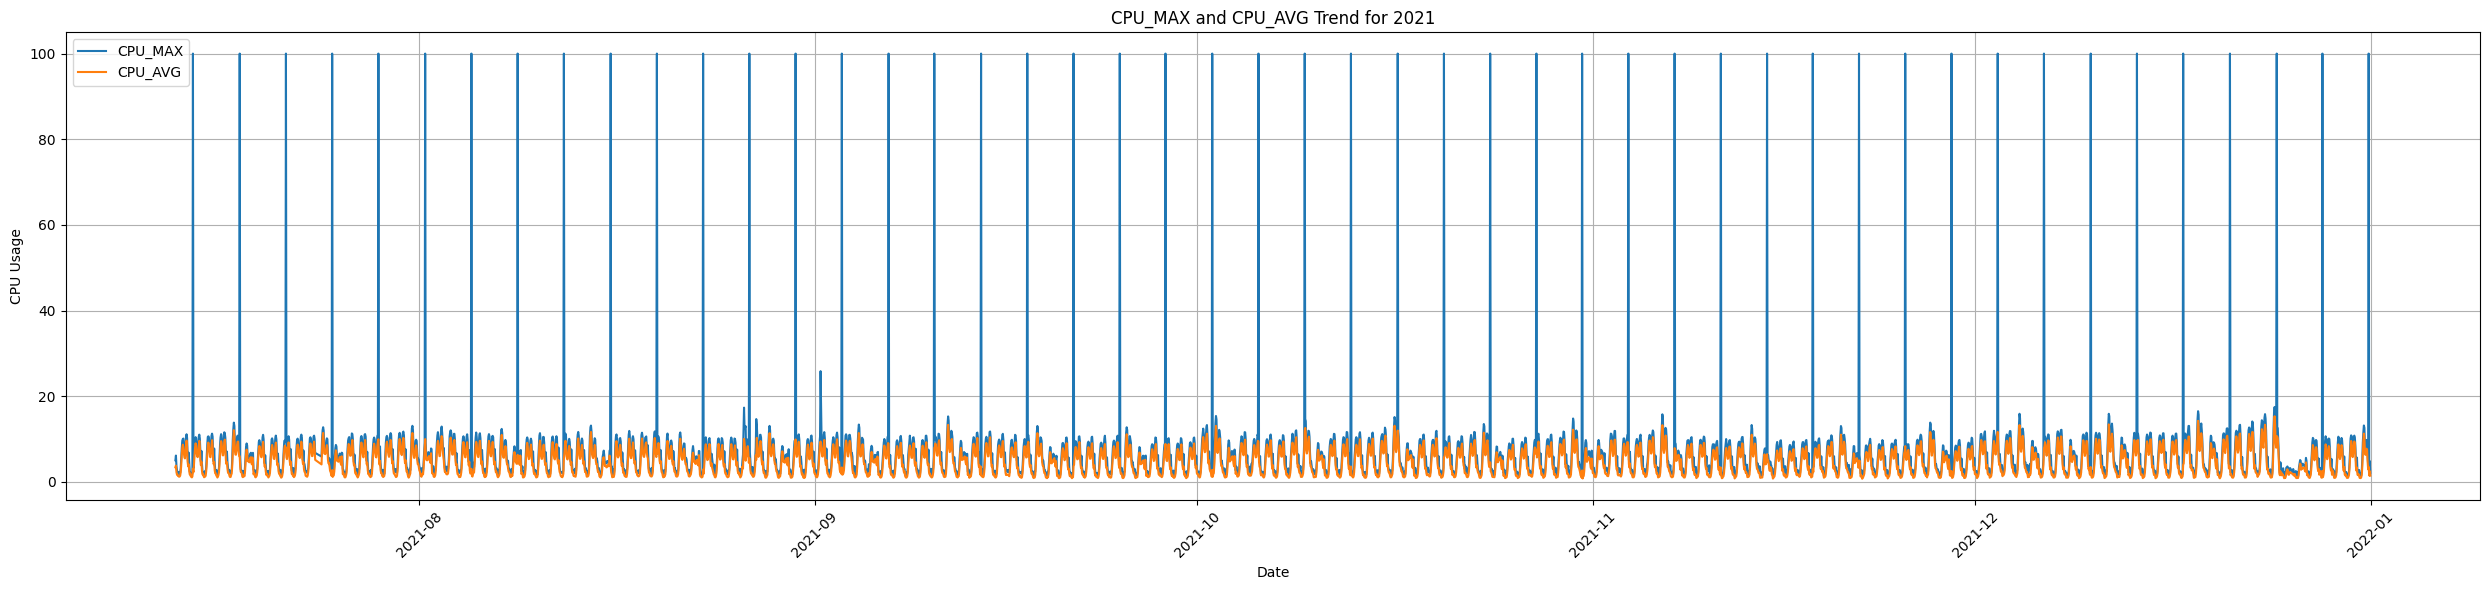

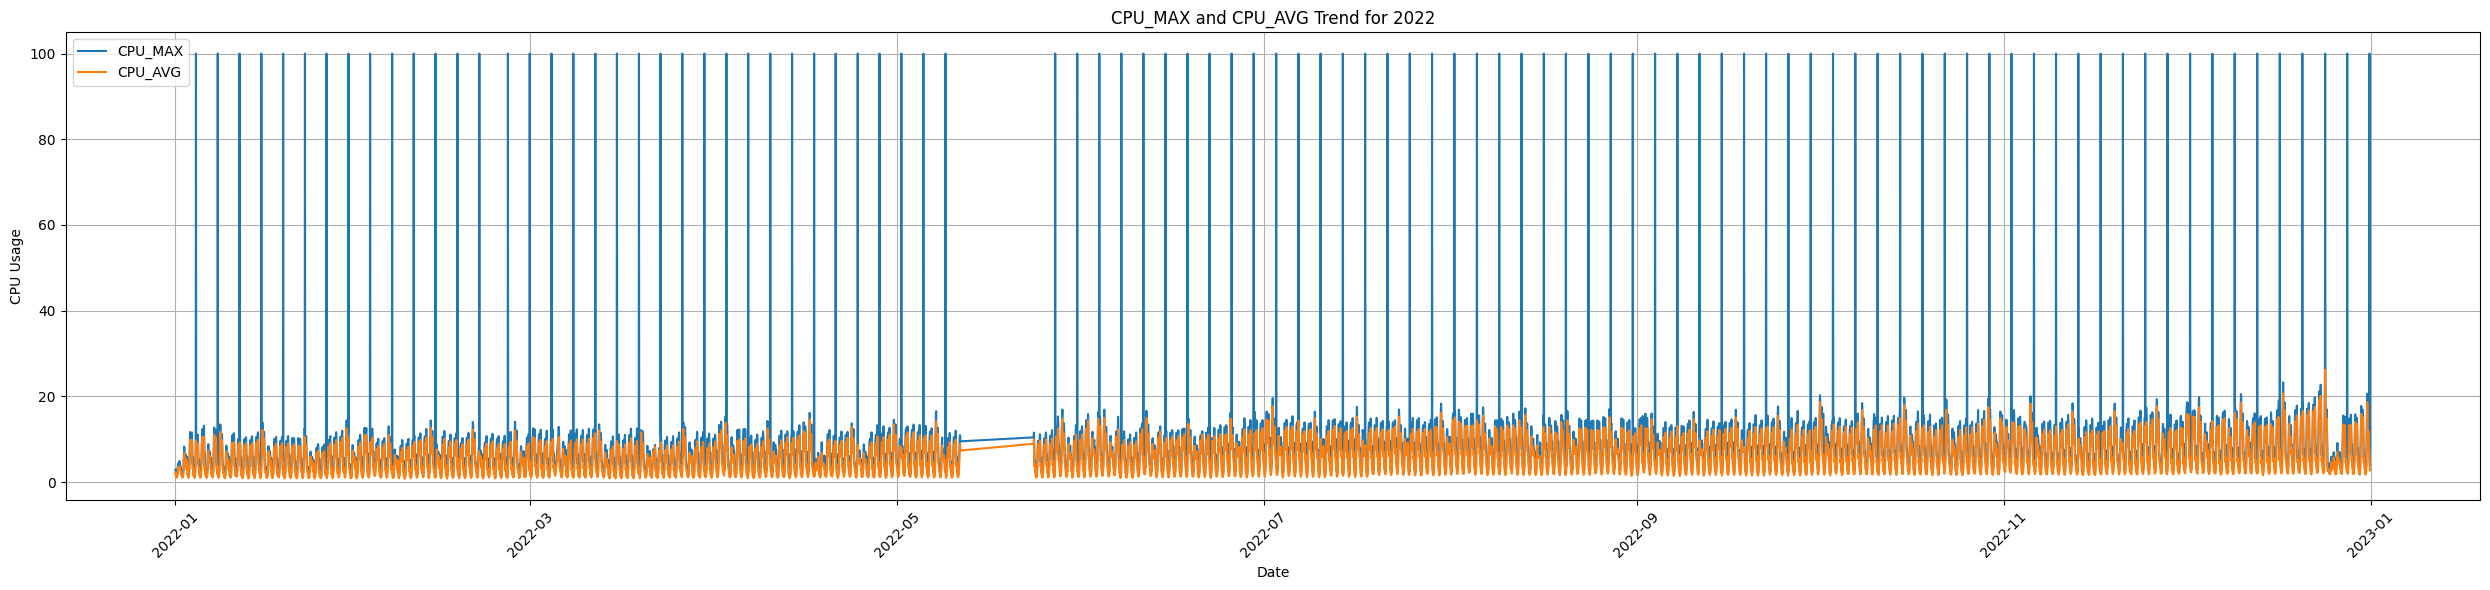

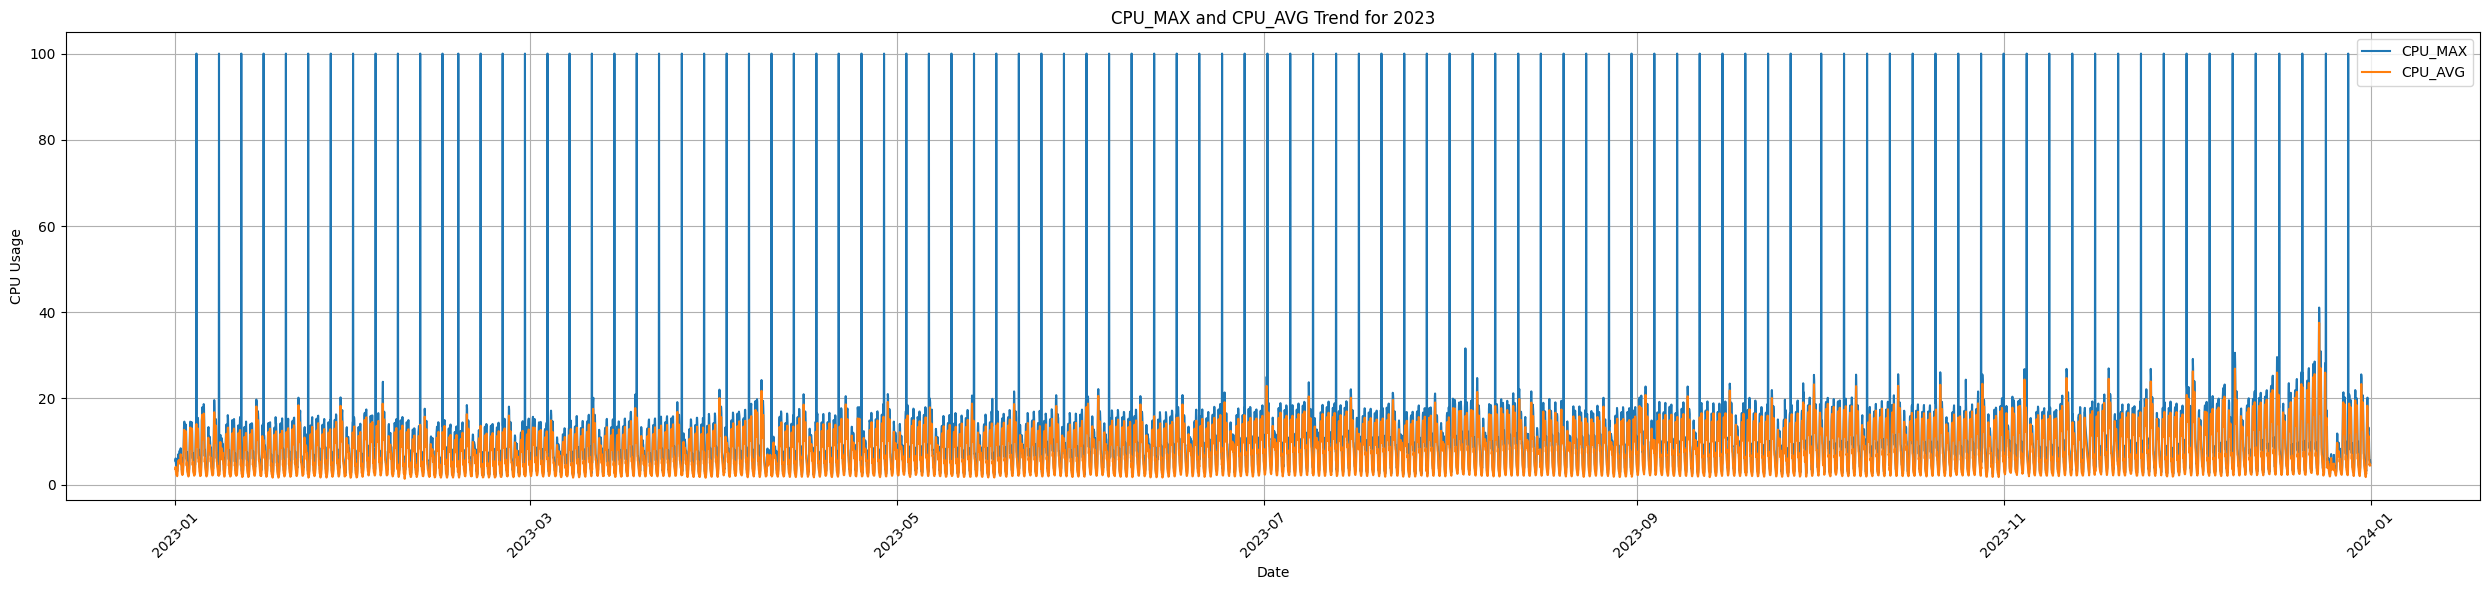

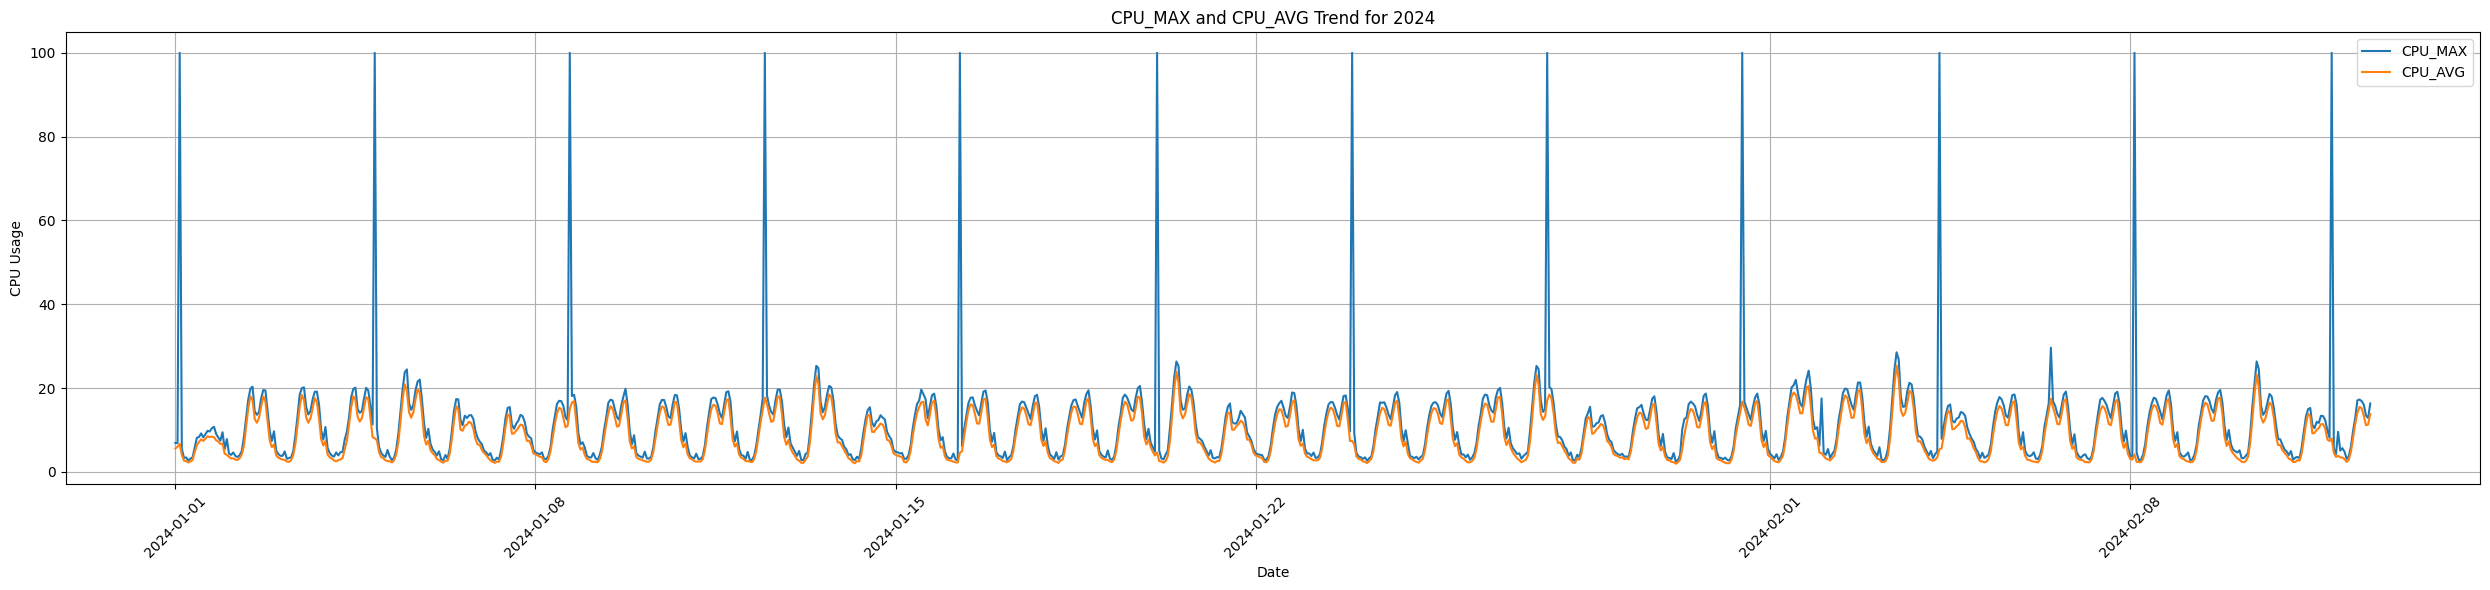

In [12]:
import matplotlib.pyplot as plt

# Convert 'DT' column to datetime type
result_df['DT'] = pd.to_datetime(result_df['DT'])

# Extract year from 'DT' column
result_df['Year'] = result_df['DT'].dt.year

# Get unique years
unique_years = result_df['Year'].unique()

# Plot for each year
for year in unique_years:
    year_df = result_df[result_df['Year'] == year]
    plt.figure(figsize=(25, 6))
    plt.plot(year_df['DT'], year_df['CPU_MAX'], label='CPU_MAX')
    plt.plot(year_df['DT'], year_df['CPU_AVG'], label='CPU_AVG')
    plt.title(f'CPU_MAX and CPU_AVG Trend for {year}')
    plt.xlabel('Date')
    plt.ylabel('CPU Usage')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [13]:
print(', '.join([f"{col}:{dtype}" for col, dtype in result_df.dtypes.items()]))
result_df.head()

DT:datetime64[ns], Fermo:float64, CPU_MAX:float64, CPU_AVG:float64, NMSG:float64, TO500RT:float64, ANOMALY:object, Year:int64


,DT,Fermo,CPU_MAX,CPU_AVG,NMSG,TO500RT,ANOMALY,Year
0,2021-07-12 21:00:00,0.0,5.04,3.39,377913.0,1.0,NO,2021
1,2021-07-12 22:00:00,0.0,6.14,3.80,313887.0,2.0,NO,2021
2,2021-07-12 23:00:00,0.0,3.70,2.24,198643.0,0.0,NO,2021
3,2021-07-13 00:00:00,0.0,2.65,1.68,106526.0,0.0,NO,2021
4,2021-07-13 01:00:00,0.0,2.12,1.76,66607.0,0.0,NO,2021


In [14]:
# Assuming 'result_df' is your DataFrame

# X_train will contain all columns except 'ANOMALY'
X_train = result_df.drop(columns=['ANOMALY',"TO500RT","Year","Fermo"])

# y_train will contain only the 'ANOMALY' column
y_train = result_df[['DT', 'ANOMALY']]

display(X_train.head())
display(y_train.head())

,DT,CPU_MAX,CPU_AVG,NMSG
0,2021-07-12 21:00:00,5.04,3.39,377913.0
1,2021-07-12 22:00:00,6.14,3.80,313887.0
2,2021-07-12 23:00:00,3.70,2.24,198643.0
3,2021-07-13 00:00:00,2.65,1.68,106526.0
4,2021-07-13 01:00:00,2.12,1.76,66607.0


,DT,ANOMALY
0,2021-07-12 21:00:00,NO
1,2021-07-12 22:00:00,NO
2,2021-07-12 23:00:00,NO
3,2021-07-13 00:00:00,NO
4,2021-07-13 01:00:00,NO


In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf

mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["axes.grid"] = False

2024-04-02 15:40:25.222073: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 15:40:25.566936: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 15:40:25.567037: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 15:40:25.635840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-02 15:40:25.805542: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-02 15:40:25.807646: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [141]:
df = result_df[["DT","NMSG", "CPU_MAX", "CPU_AVG", "ANOMALY"]]
# Replace 'NO' with 0.0 and 'YES' with 1.0 in the 'ANOMALY' column
df['ANOMALY'] = df['ANOMALY'].replace({'NO': 0.0, 'YES': 1.0})
df.head()

/tmp/ipykernel_32719/3282632157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ANOMALY'] = df['ANOMALY'].replace({'NO': 0.0, 'YES': 1.0})


,DT,NMSG,CPU_MAX,CPU_AVG,ANOMALY
0,2021-07-12 21,377913.0,5.04,3.39,0.0
1,2021-07-12 22,313887.0,6.14,3.80,0.0
2,2021-07-12 23,198643.0,3.70,2.24,0.0
3,2021-07-13 00,106526.0,2.65,1.68,0.0
4,2021-07-13 01,66607.0,2.12,1.76,0.0


In [142]:
# Convert 'DT' column to datetime
df['DT'] = pd.to_datetime(df['DT'])
# # Split datetime into year, month, day, and hour
# df['year'] = df['DT'].dt.year
# df['month'] = df['DT'].dt.month
# df['day'] = df['DT'].dt.day
# df['hour'] = df['DT'].dt.hour

# # Drop the original 'DT' column if needed
# # df.drop('DT', axis=1, inplace=True)

# Rename 'DT' column to 'date'
df.rename(columns={'DT': 'date'}, inplace=True)
# Set 'date' column as index
df.set_index('date', inplace=True)
df

/tmp/ipykernel_32719/3793811550.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DT'] = pd.to_datetime(df['DT'])
/tmp/ipykernel_32719/3793811550.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'DT': 'date'}, inplace=True)


,NMSG,CPU_MAX,CPU_AVG,ANOMALY
date,,,,
2021-07-12 21:00:00,377913.0,5.04,3.39,0.0
2021-07-12 22:00:00,313887.0,6.14,3.80,0.0
2021-07-12 23:00:00,198643.0,3.70,2.24,0.0
2021-07-13 00:00:00,106526.0,2.65,1.68,0.0
2021-07-13 01:00:00,66607.0,2.12,1.76,0.0
...,...,...,...,...
2024-02-12 12:00:00,1456545.0,16.86,15.17,0.0
2024-02-12 13:00:00,1251404.0,16.01,13.30,0.0
2024-02-12 14:00:00,1028825.0,13.42,11.12,0.0


In [143]:
# save to file
df.to_csv('df_input_1.csv')

In [116]:
len(df)

22326

array([<Axes: xlabel='DT'>, <Axes: xlabel='DT'>, <Axes: xlabel='DT'>,
       <Axes: xlabel='DT'>], dtype=object)

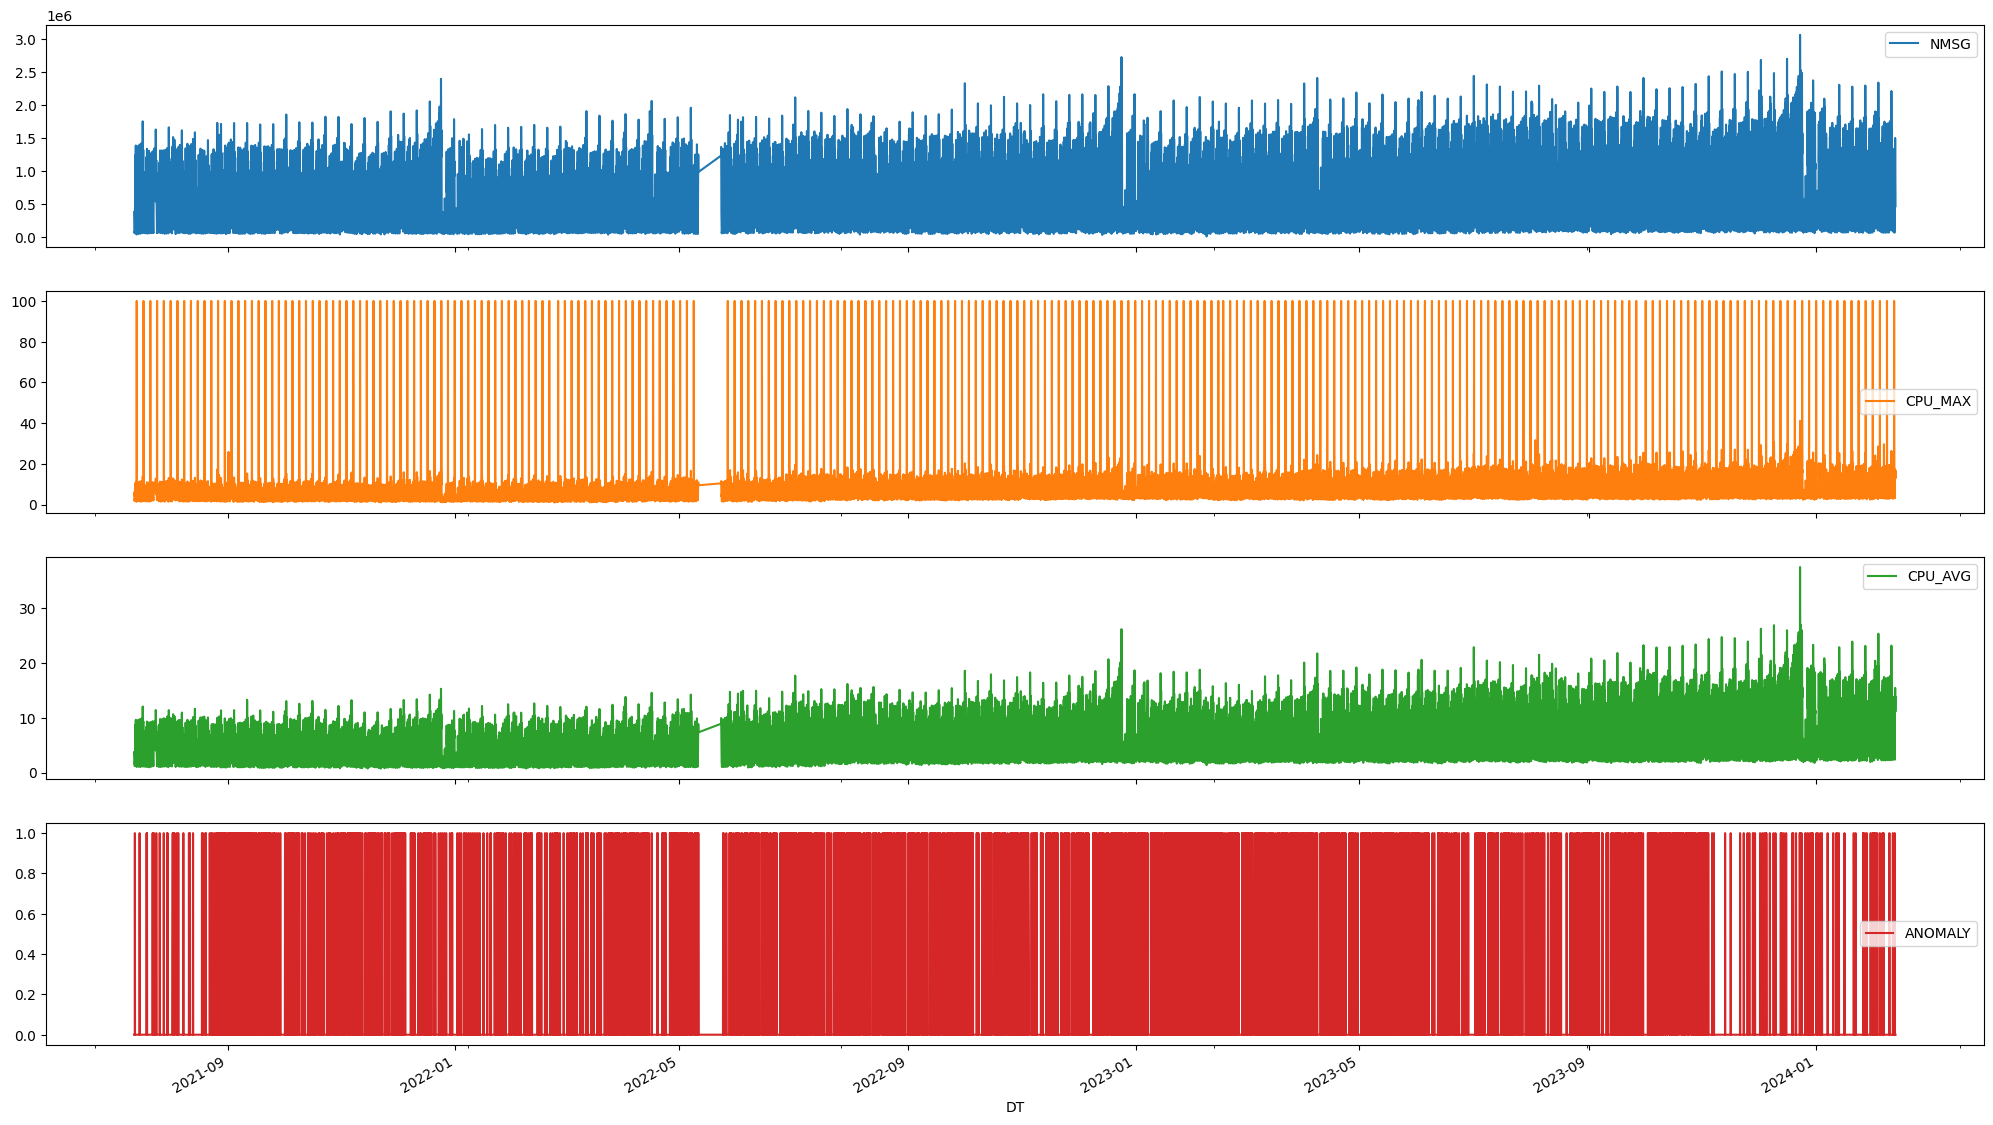

In [19]:
df.set_index("DT")[["NMSG", "CPU_MAX", "CPU_AVG", "ANOMALY"]].plot(subplots=True, figsize=(25, 15))


In [111]:
df_input = df[["NMSG", "CPU_MAX", "CPU_AVG", "ANOMALY"]]
df_input.head()

,NMSG,CPU_MAX,CPU_AVG,ANOMALY
0,377913.0,5.04,3.39,0.0
1,313887.0,6.14,3.80,0.0
2,198643.0,3.70,2.24,0.0
3,106526.0,2.65,1.68,0.0
4,66607.0,2.12,1.76,0.0


In [112]:
df_input

,NMSG,CPU_MAX,CPU_AVG,ANOMALY
0,377913.0,5.04,3.39,0.0
1,313887.0,6.14,3.80,0.0
2,198643.0,3.70,2.24,0.0
3,106526.0,2.65,1.68,0.0
4,66607.0,2.12,1.76,0.0
...,...,...,...,...
22321,1456545.0,16.86,15.17,0.0
22322,1251404.0,16.01,13.30,0.0
22323,1028825.0,13.42,11.12,0.0
22324,1086515.0,12.86,11.28,0.0


In [114]:
df_input.dtypes

NMSG       float64
CPU_MAX    float64
CPU_AVG    float64
ANOMALY    float64
dtype: object

In [113]:
import pandas as pd

# Assuming df is your DataFrame
df_input.to_csv("df_input.csv", index=False)
